In [2]:
pip install keras

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 324.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.9 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.8/736.8 kB 15.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.8/523.8 kB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --ignore-installed --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 497.7 kB/s eta 0:00:00a 0:00:01
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached optree-0.12.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (47 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 MB 2.3 MB/s eta 0:00:0000:0100:03
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 4.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 5.4 MB/s eta 0:00:0000:0100:01
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [8]:
# Load the dataset
data = pd.read_csv("/Users/ratan/Documents/test projects/GoogleStockPrice.csv")

# Inspect the first few rows of the dataset
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,18.003504,18.193193,17.931683,18.099348,18.099348,101550348
1,2013-01-03,18.141392,18.316566,18.036036,18.109859,18.109859,92635272
2,2013-01-04,18.251753,18.555305,18.210211,18.467718,18.467718,110429460
3,2013-01-07,18.404655,18.503002,18.282784,18.387136,18.387136,66161772
4,2013-01-08,18.406906,18.425926,18.128880,18.350851,18.350851,66976956


In [9]:
#Preprocessing the Data
# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the stock prices (Feature scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])


In [10]:
#Create Dataset for LSTM
# Helper function to create dataset with time steps
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Set time step to 60 (i.e., look back 60 days)
time_step = 60


In [12]:
#Split the Data
# Split data into training (80%) and testing (20%)
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_size]
test_data = scaled_data[training_size:]

# Prepare the training and testing datasets for the LSTM model
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data to fit the LSTM input [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [14]:
#Build the LSTM Model, Two LSTM layers. Dropout layers for regularization and Dense layers to predict the stock price.
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/Users/ratan/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0194
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0012
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.9743e-04
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.1153e-04
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.2817e-04
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.6438e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 6.2933e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 6.7194e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 5.8972e-04
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.5022e-04
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.9875e-04
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 4.8365e-04
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 5.0573e-04
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 4.7179e-04
Epoch 15/

In [16]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the original stock prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [17]:
# Calculate RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train RMSE: 51.826704940111796
Test RMSE: 116.83100913616224


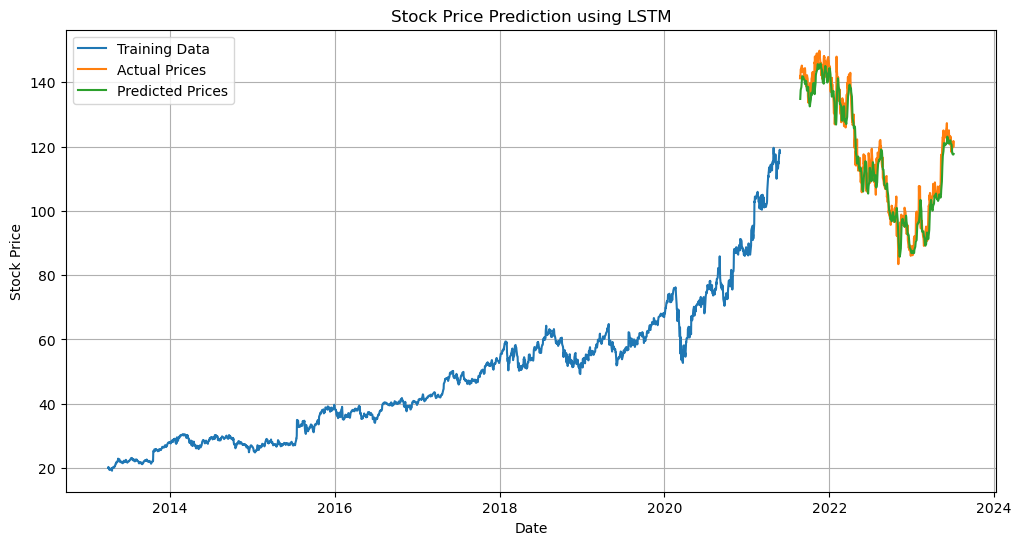

In [19]:
# Plot the results
plt.figure(figsize=(12,6))
train_len = len(train_data)

# Plot original vs predicted prices
plt.plot(data.index[time_step:training_size], scaler.inverse_transform(train_data[time_step:]), label='Training Data')
plt.plot(data.index[training_size+time_step:], scaler.inverse_transform(test_data[time_step:]), label='Actual Prices')

# Adjust the indices to match the length of test predictions
plt.plot(data.index[training_size+time_step+1:], test_predict, label='Predicted Prices')

plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


This project focuses on building a Long Short-Term Memory (LSTM) neural network to predict stock prices based on historical data. The dataset used for training and testing includes stock price information (such as opening, closing, high, low, and volume) from Google Stock Price. The project covers the full pipeline, from data preprocessing to model evaluation, using Python and popular libraries like Keras, NumPy, and Pandas.

Key Highlights
Problem: Predict future stock prices based on past data.
Goal: Use machine learning to forecast stock prices with minimal error.
Model: LSTM Neural Network (suitable for time series data).
Tools: Python, Jupyter Notebook, Keras, Scikit-learn, Matplotlib.
Dataset: Google Stock Price Dataset.